# Project 6
Outline:
 1. Look at distribution of data
 2. Fit initial model & check metrics
 3. Check Assumptions
 4. Look at autocorrelation
 5. Use seasonality in model
 6. Check final model with seasons metrics

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set_theme()

## 1. Data Exploration

In [3]:
hydro = pd.read_csv("data/RRCA_baseflow.csv")
hydro.head()

,Date,Segment_id,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,Observed
0,710732,144,1086190,14476800,0.59,18.99,0.0,0.145161
1,710763,144,1086190,14476800,0.97,29.63,0.0,0.445161
2,710791,144,1086190,14476800,1.34,29.63,0.0,1.332203
3,710822,144,1086190,14476800,1.79,29.63,0.0,2.932203
4,710852,144,1086190,14476800,8.23,29.63,0.0,3.728689


In [5]:
# fix date variable, add days var representing days since 1900-01-01
hydro['days'] = hydro.Date - 693963
hydro['Date'] = pd.to_datetime(hydro['days'] ,origin='1900-01-01', unit='D')
hydro.head()

,Date,Segment_id,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,Observed,days
0,1945-11-30,144,1086190,14476800,0.59,18.99,0.0,0.145161,16769
1,1945-12-31,144,1086190,14476800,0.97,29.63,0.0,0.445161,16800
2,1946-01-28,144,1086190,14476800,1.34,29.63,0.0,1.332203,16828
3,1946-02-28,144,1086190,14476800,1.79,29.63,0.0,2.932203,16859
4,1946-03-30,144,1086190,14476800,8.23,29.63,0.0,3.728689,16889


<AxesSubplot: xlabel='Date', ylabel='Observed'>

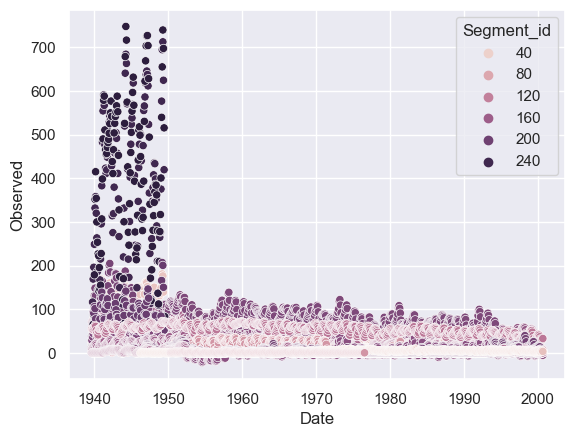

In [9]:
# look at target variable over time, split by segment_id
sns.scatterplot(hydro, x='Date', y='Observed', hue='Segment_id')

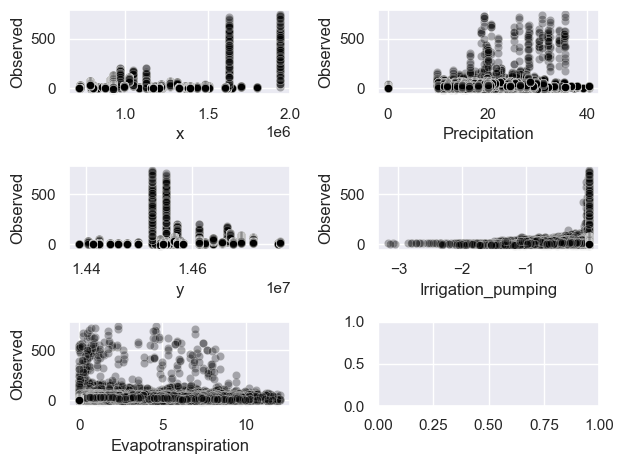

In [39]:
# check out explanatory variables in comparison to response variable
fig, axs = plt.subplots(3, 2)
sns.scatterplot(data=hydro, x='x', y='Observed', ax=axs[0,0], alpha=0.3, color='black')
sns.scatterplot(data=hydro, x='y', y='Observed', ax=axs[1,0], alpha=0.3, color='black')
sns.scatterplot(data=hydro, x='Evapotranspiration', y='Observed', ax=axs[2,0], alpha=0.3, color='black')
sns.scatterplot(data=hydro, x='Precipitation', y='Observed', ax=axs[0,1], alpha=0.3, color='black')
sns.scatterplot(data=hydro, x='Irrigation_pumping', y='Observed', ax=axs[1,1], alpha=0.3, color='black')


plt.tight_layout()
plt.show()


<AxesSubplot: xlabel='Irrigation_pumping', ylabel='Observed'>

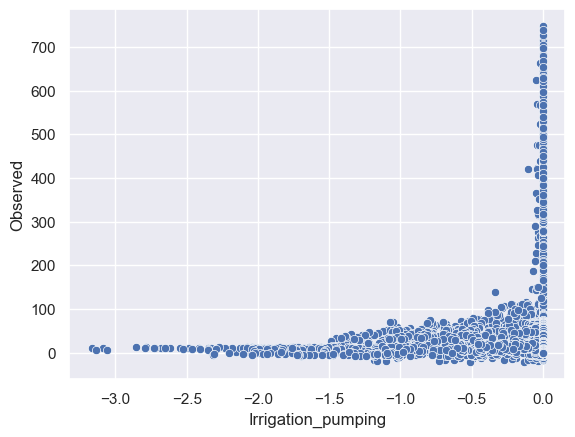

In [41]:
# irrigation relationship looks interesting
sns.scatterplot(hydro, x='Irrigation_pumping', y='Observed')

## 2. Initial Model
Here we will fit an initial model and see if it meets the linear model assumptions

In [18]:
# since x and y have to do with a discrete location on the river, we will also use them as a dummy variable,
# but we'll keep the separate x and y to predict as quantitative and see if it works
hydro['xy'] = hydro.x.astype(str) + ', ' + hydro.y.astype(str)
X = pd.get_dummies(hydro, columns=["Segment_id", "xy"], drop_first=True).drop(columns=["Date", "Observed"])
X = sm.add_constant(X)
y = hydro["Observed"]
display(X.head())
display(y.head())

,const,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,days,Segment_id_51,Segment_id_53,Segment_id_55,...,"xy_790510, 14424000","xy_806350, 14550720","xy_838030, 14556000","xy_859150, 14714400","xy_874990, 14556000","xy_906670, 14693280","xy_927790, 14540160","xy_927790, 14550720","xy_970030, 14571840","xy_991150, 14714400"
0,1.0,1086190,14476800,0.59,18.99,0.0,16769,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1086190,14476800,0.97,29.63,0.0,16800,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1086190,14476800,1.34,29.63,0.0,16828,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1086190,14476800,1.79,29.63,0.0,16859,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,1086190,14476800,8.23,29.63,0.0,16889,0,0,0,...,0,0,0,0,0,0,0,0,0,0


0    0.145161
1    0.445161
2    1.332203
3    2.932203
4    3.728689
Name: Observed, dtype: float64

In [45]:
model_0 = sm.OLS(y, X)
results_0 = model_0.fit()
print(results_0.summary())


                            OLS Regression Results                            
Dep. Variable:               Observed   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     1411.
Date:                Tue, 21 Mar 2023   Prob (F-statistic):               0.00
Time:                        22:08:44   Log-Likelihood:                -71739.
No. Observations:               15591   AIC:                         1.436e+05
Df Residuals:                   15541   BIC:                         1.440e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2514 

In [48]:
# try dropping x & y since we made them categorical
X = X.drop(columns=['x', 'y'])

model_1 = sm.OLS(y, X)
results_1 = model_1.fit()
print(results_1.summary())

                            OLS Regression Results                            
Dep. Variable:               Observed   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     1411.
Date:                Tue, 21 Mar 2023   Prob (F-statistic):               0.00
Time:                        22:10:44   Log-Likelihood:                -71739.
No. Observations:               15591   AIC:                         1.436e+05
Df Residuals:                   15541   BIC:                         1.440e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   38.0198 

In [49]:
# check assumptions (many use the errors)
y_pred = results_1.predict(X)
errors = y - y_pred

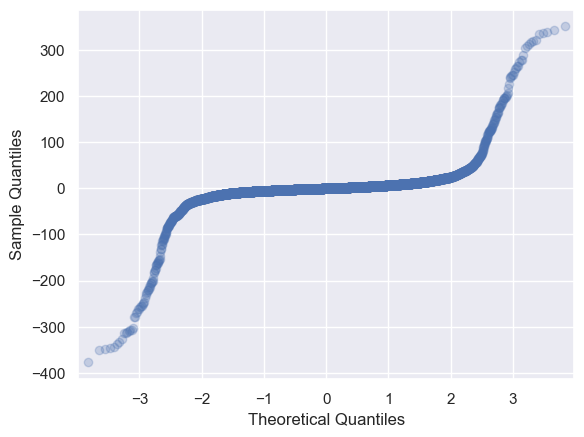

In [50]:
# normality of errors
sm.qqplot(errors, alpha=0.25)
plt.show()

<AxesSubplot: >

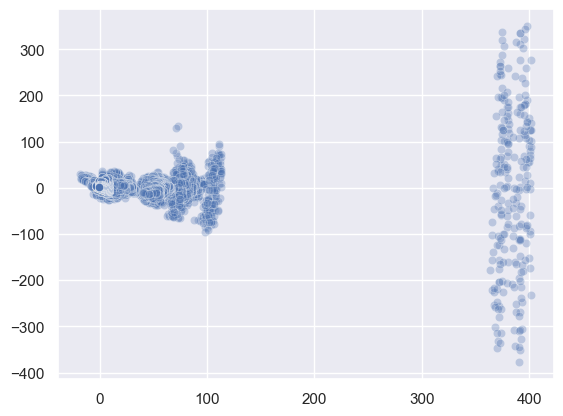

In [57]:
# check error vs pred
sns.scatterplot(x=y_pred, y=errors, alpha=0.3)

## 3. Fix Violated Assumptions
Now we attempt to fix the violated assumptions, and will recheck the model for violations and check it's metrics

## 4. Time-Series Feature Engineering
Here we will attempt to improve our model by looking at whether autocorrelation exists, and if it does we will create lag features.

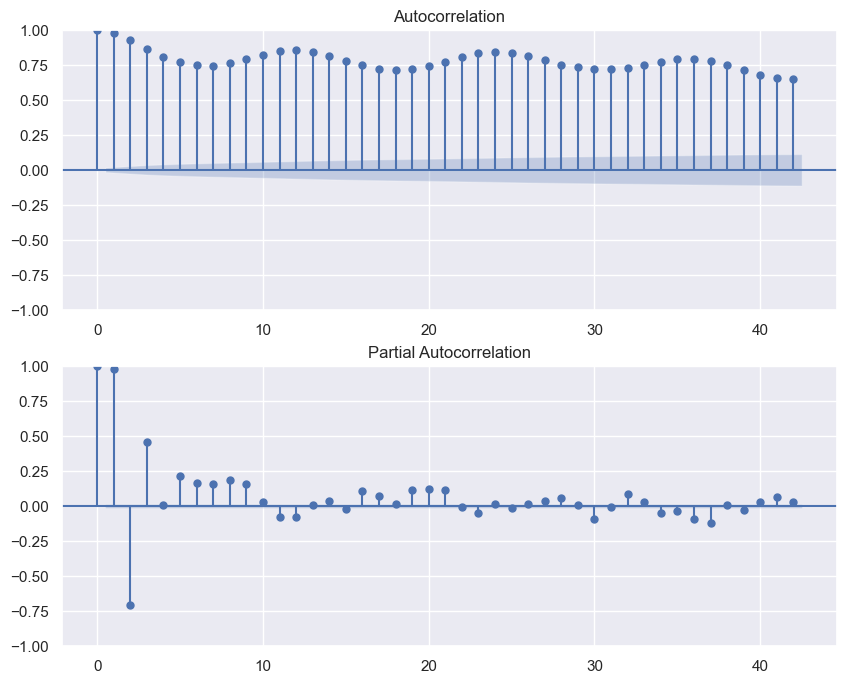

In [53]:
# look at autocorrelation
fig, axes = plt.subplots(2, 1, figsize=(10,8))
plot_acf(y, ax=axes[0])
plot_pacf(y, ax=axes[1])
plt.show()

This strongly suggests that the observed baseflow is highly influenced by previous measurements of observed baseflow

In [ ]:
# add season feature to account for time


## 5. Final Model and Conclusions

In [59]:
# standardize to interpret coefficients
quant_cols = ['Evapotranspiration', 'Precipitation', 'Irrigation_pumping']
for col in quant_cols:
    X[col] = (X[col] - X[col].mean()) / X[col].std()

In [62]:
model_3 = sm.OLS(y, X)
results_3 = model_3.fit()
print(results_3.summary())

                            OLS Regression Results                            
Dep. Variable:               Observed   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     1411.
Date:                Tue, 21 Mar 2023   Prob (F-statistic):               0.00
Time:                        22:28:02   Log-Likelihood:                -71739.
No. Observations:               15591   AIC:                         1.436e+05
Df Residuals:                   15541   BIC:                         1.440e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   43.7536 

In [68]:
results_3.params.sort_values(ascending=False).head(20)

Segment_id_256          174.287227
xy_1941550, 14524320    174.287227
xy_1630030, 14550720    164.815599
Segment_id_239          164.815599
xy_1049230, 14666880     50.154619
Segment_id_157           49.815308
const                    43.753631
Segment_id_194           32.774946
xy_970030, 14571840      32.774946
xy_927790, 14550720      20.298808
Segment_id_188           20.298808
xy_1128430, 14614080     15.022483
Segment_id_205           15.022483
Segment_id_53            14.119456
xy_785230, 14566560       9.449797
Segment_id_130            9.449797
xy_906670, 14693280       7.021069
Segment_id_147            7.021069
Precipitation             6.120623
Segment_id_170            4.755136
dtype: float64